# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

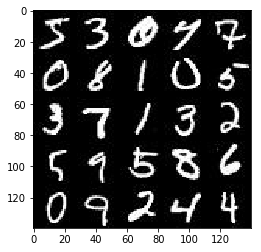

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

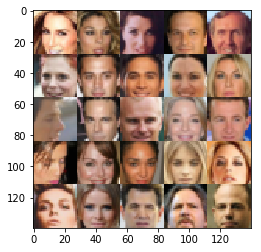

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
        
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    x = images
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        ## 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #saver = tf.train.Saver()

    steps = 0
    z_size = 100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                x = batch_images
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                   

        #saver.save(sess, './checkpoints/generator.ckpt')

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 0.9673
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 2.1169... Generator Loss: 4.5514
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 2.6729
Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 2.0526
Epoch 1/2... Discriminator Loss: 1.0268... Generator Loss: 1.2178
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 0.7606


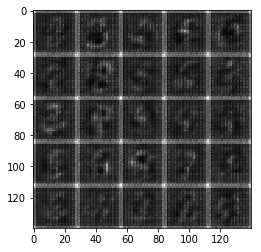

Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.3471
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 0.8040... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 0.4510... Generator Loss: 2.4379
Epoch 1/2... Discriminator Loss: 2.5738... Generator Loss: 0.1637
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.4043
Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.4457
Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 4.1209
Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.4119
Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 0.9607


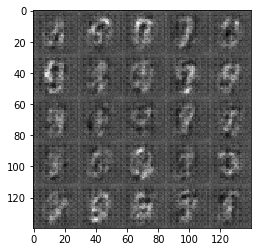

Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 1.2237
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.6906
Epoch 1/2... Discriminator Loss: 0.7066... Generator Loss: 2.0414
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 1.2163
Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.3691
Epoch 1/2... Discriminator Loss: 0.5969... Generator Loss: 2.3729
Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 2.1372
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 0.5590... Generator Loss: 2.3672


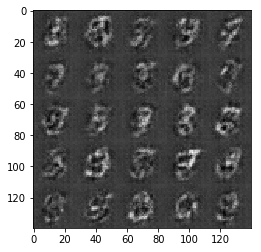

Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 2.3391
Epoch 1/2... Discriminator Loss: 0.5001... Generator Loss: 2.3889
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 2.2763
Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 1.7922
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 2.1656
Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 1.3956
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 1.4262
Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 1.6580
Epoch 1/2... Discriminator Loss: 0.5042... Generator Loss: 2.2476


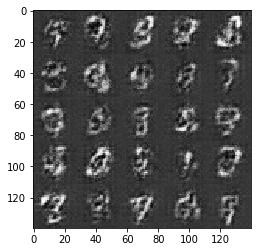

Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.4331
Epoch 1/2... Discriminator Loss: 0.5743... Generator Loss: 1.7315
Epoch 1/2... Discriminator Loss: 0.5391... Generator Loss: 3.0005
Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 1.6262
Epoch 1/2... Discriminator Loss: 0.8077... Generator Loss: 1.0861
Epoch 1/2... Discriminator Loss: 0.5281... Generator Loss: 2.6166
Epoch 1/2... Discriminator Loss: 0.4951... Generator Loss: 2.1639
Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 2.7097
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.7881
Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 2.2453


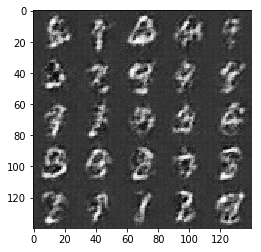

Epoch 1/2... Discriminator Loss: 0.6196... Generator Loss: 1.6928
Epoch 1/2... Discriminator Loss: 0.5356... Generator Loss: 2.0936
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 1.9110
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 2.0220
Epoch 1/2... Discriminator Loss: 0.5484... Generator Loss: 2.4559
Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 1.6036
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 1.5093
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 2.7957
Epoch 1/2... Discriminator Loss: 0.5118... Generator Loss: 2.0481


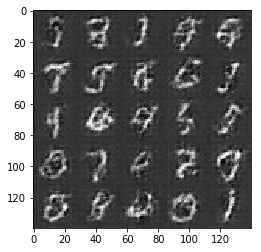

Epoch 1/2... Discriminator Loss: 0.6709... Generator Loss: 2.9339
Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 2.0400
Epoch 2/2... Discriminator Loss: 1.4509... Generator Loss: 0.5268
Epoch 2/2... Discriminator Loss: 0.4877... Generator Loss: 2.6529
Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 4.5702
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 0.4902... Generator Loss: 2.5691
Epoch 2/2... Discriminator Loss: 0.4192... Generator Loss: 3.0285
Epoch 2/2... Discriminator Loss: 0.4093... Generator Loss: 2.8664
Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 2.3149


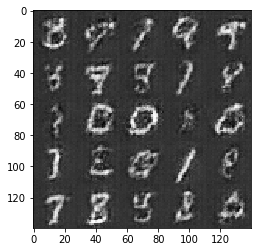

Epoch 2/2... Discriminator Loss: 0.3929... Generator Loss: 3.7786
Epoch 2/2... Discriminator Loss: 0.4258... Generator Loss: 2.8903
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 1.9572
Epoch 2/2... Discriminator Loss: 0.8735... Generator Loss: 2.8527
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.5782
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.3657
Epoch 2/2... Discriminator Loss: 1.5265... Generator Loss: 0.4260
Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 1.7761
Epoch 2/2... Discriminator Loss: 0.4562... Generator Loss: 2.4476
Epoch 2/2... Discriminator Loss: 0.4335... Generator Loss: 3.5323


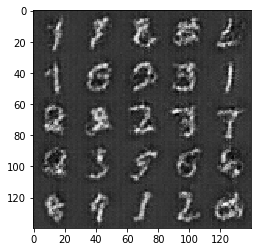

Epoch 2/2... Discriminator Loss: 0.4516... Generator Loss: 2.4718
Epoch 2/2... Discriminator Loss: 0.4403... Generator Loss: 2.6186
Epoch 2/2... Discriminator Loss: 0.4509... Generator Loss: 2.3550
Epoch 2/2... Discriminator Loss: 4.0023... Generator Loss: 0.0520
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.8982
Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 1.3155
Epoch 2/2... Discriminator Loss: 0.5100... Generator Loss: 2.3400
Epoch 2/2... Discriminator Loss: 1.5333... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 0.4891... Generator Loss: 2.3157
Epoch 2/2... Discriminator Loss: 0.4827... Generator Loss: 2.1285


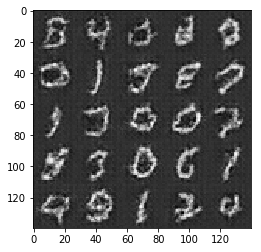

Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.3996
Epoch 2/2... Discriminator Loss: 0.4255... Generator Loss: 2.6505
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 3.0961
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.1476
Epoch 2/2... Discriminator Loss: 0.6209... Generator Loss: 1.6735
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 0.5143... Generator Loss: 2.1931
Epoch 2/2... Discriminator Loss: 0.4447... Generator Loss: 2.4591
Epoch 2/2... Discriminator Loss: 0.4526... Generator Loss: 2.5020


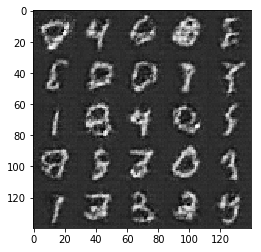

Epoch 2/2... Discriminator Loss: 0.4548... Generator Loss: 2.3395
Epoch 2/2... Discriminator Loss: 0.4468... Generator Loss: 2.4442
Epoch 2/2... Discriminator Loss: 0.7697... Generator Loss: 1.3919
Epoch 2/2... Discriminator Loss: 1.6467... Generator Loss: 2.6653
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 1.8506
Epoch 2/2... Discriminator Loss: 0.5492... Generator Loss: 2.0960
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 2.8725
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 1.9303
Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 3.8895


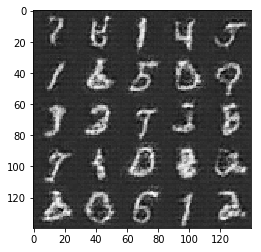

Epoch 2/2... Discriminator Loss: 0.4260... Generator Loss: 2.7905
Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 1.8537
Epoch 2/2... Discriminator Loss: 0.3745... Generator Loss: 3.4552
Epoch 2/2... Discriminator Loss: 0.4049... Generator Loss: 4.2472
Epoch 2/2... Discriminator Loss: 0.3644... Generator Loss: 3.6603
Epoch 2/2... Discriminator Loss: 0.4262... Generator Loss: 2.5634
Epoch 2/2... Discriminator Loss: 0.3824... Generator Loss: 3.2645
Epoch 2/2... Discriminator Loss: 0.3654... Generator Loss: 4.8206
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.7862
Epoch 2/2... Discriminator Loss: 1.0113... Generator Loss: 1.1499


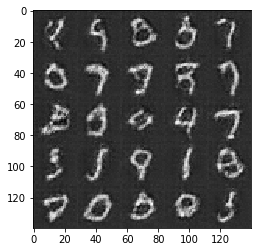

Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 1.2878
Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.5696
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 1.9278
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 2.0084
Epoch 2/2... Discriminator Loss: 0.3879... Generator Loss: 3.2153


In [15]:
batch_size = 96
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7732... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.5741
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.8257
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.6569
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.6105


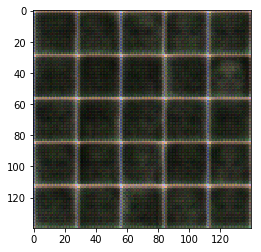

Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 2.2049
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 3.4922
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 2.4293
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 2.0237
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 2.3569
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 1.8364
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.3668
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.8282


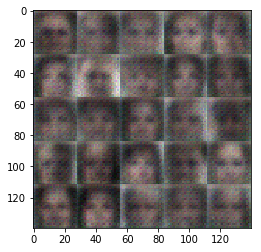

Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.8315
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 2.0764
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.7403
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.8374... Generator Loss: 0.2896


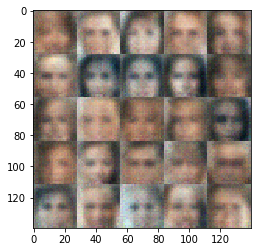

Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 3.2242
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 2.3485
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 3.0357
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.0460


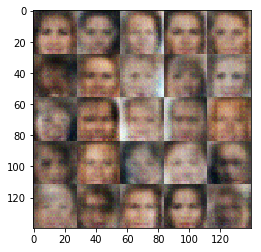

Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 3.7146
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 2.8828
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 2.5518


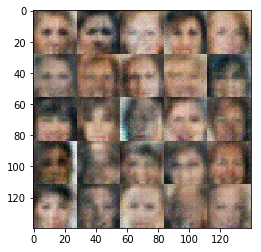

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 3.9762
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 3.7388
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 5.0716
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 3.5078
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 2.8466
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.4989
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 3.1616
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 4.3895
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 5.2255


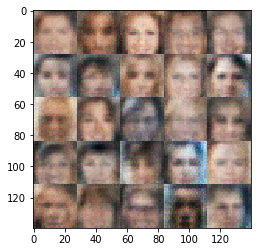

Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 5.5971
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 2.1344
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 2.0723
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 4.0636
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 6.5845
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 4.5861
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 5.6379


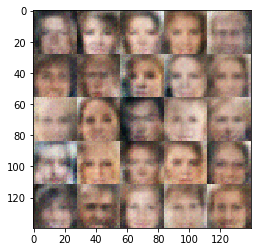

Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 3.5002
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.0997
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 3.3847
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.4010


In [14]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.